<a href="https://colab.research.google.com/github/soukhind2/PRNI_summer_school/blob/master/Copy_of_Temporal_Decoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multivariate Statistics (Decoding / MVPA) on MEG/EEG Data

**Lecture:** Alexandre Gramfort

**Tutorial:** Richard Höchenberger `<richard.hoechenberger@gmail.com>`




## Objective

This tutorial is concerned with the analysis of M/EEG data. It largely consists of two parts:

- In the **first part,** you will learn how to **import raw data,** split it into **epochs,** and calculate **evoked responses.**
- In the **second part,** we will **train a classifier** to distinguish the brain response patterns to two stimulus conditions, first on a **per-trial basis,** and then for **every time point.**

Install MNE-Python if it has not yet been installed.

In [1]:
!pip install mne

     |████████████████████████████████| 6.6MB 2.7MB/s 


First, load the mne package:

In [2]:
import mne

## Load the raw data.

Now we load the `sample` dataset. It will be downloaded automatically (approx. 2 GB).

In [3]:
from pathlib import Path

# data_path() returns a string – turn it into a Path!
sample_dir = Path(mne.datasets.sample.data_path())

# The raw data file we wish to load – an example experiment.
raw_fname = sample_dir / 'MEG/sample/sample_audvis_filt-0-40_raw.fif'

# Now, actually load the raw data.
raw = mne.io.read_raw_fif(raw_fname, preload=True)
print(raw)

Using default location ~/mne_data for sample...
Creating ~/mne_data



Verifying hash 12b75d1cb7df9dfb4ad73ed82f61094f.
Decompressing the archive: /root/mne_data/MNE-sample-data-processed.tar.gz
(please be patient, this can take some time)
Successfully extracted to: ['/root/mne_data/MNE-sample-data']
Attempting to create new mne-python configuration file:
/root/.mne/mne-python.json
Opening raw data file /root/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Current compensation grade : 0
Reading 0 ... 41699  =      0.000 ...   277.709 secs...
<Raw | sample_audvis_filt-0-40_raw.fif, 376 x 41700 (277.7 s), ~123.3 MB, data loaded>


## High-pass filter the data.

In [4]:
raw.filter(l_freq=1, h_freq=None, verbose=True)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 497 samples (3.310 sec)



<Raw | sample_audvis_filt-0-40_raw.fif, 376 x 41700 (277.7 s), ~123.3 MB, data loaded>

## View some metadata & information on the data.

In [5]:
print(raw.info)

<Info | 15 non-empty values
 bads: 2 items (MEG 2443, EEG 053)
 ch_names: MEG 0113, MEG 0112, MEG 0111, MEG 0122, MEG 0123, MEG 0121, MEG ...
 chs: 204 GRAD, 102 MAG, 9 STIM, 60 EEG, 1 EOG
 custom_ref_applied: False
 dev_head_t: MEG device -> head transform
 dig: 146 items (3 Cardinal, 4 HPI, 61 EEG, 78 Extra)
 file_id: 4 items (dict)
 highpass: 1.0 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 lowpass: 40.0 Hz
 meas_date: 2002-12-03 19:01:10 UTC
 meas_id: 4 items (dict)
 nchan: 376
 projs: PCA-v1: off, PCA-v2: off, PCA-v3: off, Average EEG reference: off
 sfreq: 150.2 Hz
>


## Extract experimental events.

First extract all experimental events. In this particular dataset, they are stored in the stimulus or trigger channel `STI 014`.

In [6]:
events = mne.find_events(raw, stim_channel='STI 014', verbose=True)

319 events found
Event IDs: [ 1  2  3  4  5 32]


Look at the design in a graphical way. We're only interested in the `auditory left` and `auditory right` conditions, encoded through event IDs `1` and `2`, respectively.

<ipython-input-7-60a9f8514f7c>:5: RuntimeWarning: event 3 missing from event_id will be ignored
  first_samp=raw.first_samp, event_id=event_id)
<ipython-input-7-60a9f8514f7c>:5: RuntimeWarning: event 4 missing from event_id will be ignored
  first_samp=raw.first_samp, event_id=event_id)
<ipython-input-7-60a9f8514f7c>:5: RuntimeWarning: event 5 missing from event_id will be ignored
  first_samp=raw.first_samp, event_id=event_id)
<ipython-input-7-60a9f8514f7c>:5: RuntimeWarning: event 32 missing from event_id will be ignored
  first_samp=raw.first_samp, event_id=event_id)


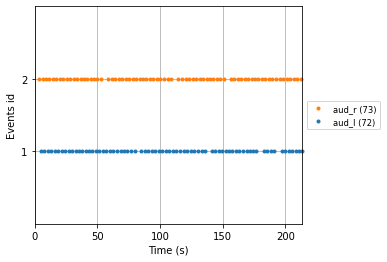

In [7]:
event_id = { 'aud_l': 1,
             'aud_r': 2 } 

fig = mne.viz.plot_events(events, sfreq=raw.info['sfreq'],
                          first_samp=raw.first_samp, event_id=event_id)

## Epoch the data.

Now that we know when the experimental events of interest happened, we are finally ready to slice the data into epochs!

Note that, since we high-pass filtered the raw data, we do not need to perform baseline correction.

In [8]:
tmin = -0.1  # Start of each epoch relative to the event marker (in seconds)
tmax = 0.4   # End of each epoch
baseline = None  # No baseline correction, data were high-pass filtered!

# Define rejection parameters: epochs with unusually high amplitudes should be dropped
# automatically.
reject = dict(eeg=100e-6, eog=200e-6)  # Amplitude threshold in Volts.

# Now actually create the epochs.
epochs = mne.Epochs(raw, tmin=tmin, tmax=tmax,
                    events=events, event_id=event_id,
                    baseline=baseline, reject=reject,
                    preload=True)  # Actually load the data into memory.

print(epochs)

145 matching events found
No baseline correction applied
Not setting metadata
Created an SSP operator (subspace dimension = 4)
4 projection items activated
Loading data for 145 events and 76 original time points ...
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EEG : ['EEG 001', 'EEG 002', 'EEG 003', 'EEG 004', 'EEG 007']
    Rejecting  epoch based on EEG : ['EEG 001', 'EEG 002', 'EEG 003', 'EEG 007']
    Rejecting  epoch based on EEG : ['EEG 003', 'EEG 007']
    Rejecting  epoch based on EEG : ['EEG 003', 'EEG 007']
    Rejecting  epoch based on EEG : ['EEG 001', 'EEG 002', 'EEG 003', 'EEG 007']
    Rejecting  epoch based on EEG : ['EEG 007']
    Rejecting  epoch based on EEG : ['EEG 001', 'EEG 002', 'EEG 003', 'EEG 007']
8 bad epochs dropped
<Epochs  |   137 events (all good), -0.0998976 - 0.39959 sec, baseline off, ~33.5 MB, data loaded,
 'aud_l': 68
 'aud_r': 69>


## Calculate evoked responses (ERF & ERP).

Display the evoked responses and visualize the differences between left and right stimulation. We use "spatial" colors for the traces, which encode the sensor location (legend shown in the top-left corner of the figures).

Text(0.5, 0.98, 'Left – Right')

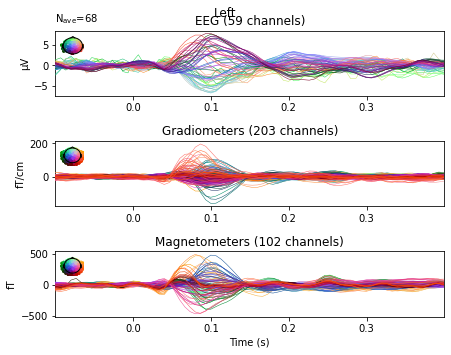

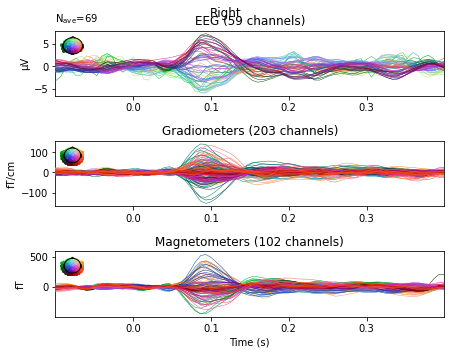

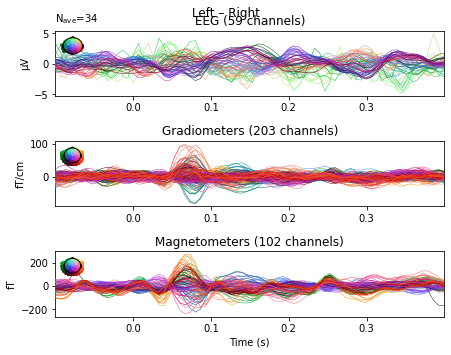

In [9]:
evoked_left = epochs['aud_l'].average()
evoked_right = epochs['aud_r'].average()

# Constrast = Left - Right stimulation.
evoked_contrast = mne.combine_evoked([evoked_left, evoked_right],
                                     weights=[1, -1])

# Plot the results. The only reason we're using show=False here is
# because otherwise, Jupyter Notebook sometimes may produce multiple
# figures per plotting command. Otherwise, this should not be
# necessary.
fig = evoked_left.plot(spatial_colors=True, show=False)
fig.suptitle('Left')

fig = evoked_right.plot(spatial_colors=True, show=False)
fig.suptitle('Right')

fig = evoked_contrast.plot(spatial_colors=True, show=False)
fig.suptitle('Left – Right')


## Plot some topographies

Text(0.5, 0.98, 'Left – Right')

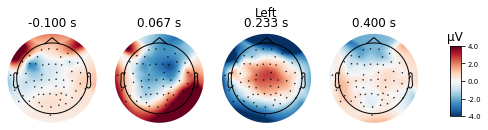

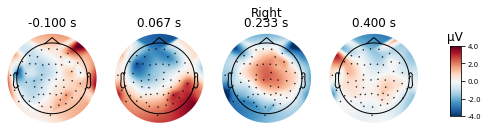

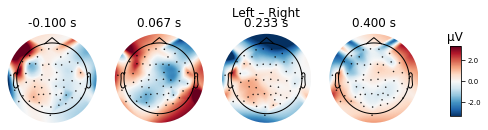

In [10]:
vmin, vmax = -4, 4  # Colorbar range – set to None, None for automatic scaling.
fig = evoked_left.plot_topomap(ch_type='eeg', contours=0, vmin=vmin, vmax=vmax,
                               show=False)
fig.suptitle('Left')

fig = evoked_right.plot_topomap(ch_type='eeg', contours=0, vmin=vmin, vmax=vmax,
                                show=False)
fig.suptitle('Right')

# For the contrast, we allow MNE to scale the colorbar automatically.
fig = evoked_contrast.plot_topomap(ch_type='eeg', contours=0, show=False)
fig.suptitle('Left – Right')

## Now let's see if we can classify single trials.

### Equalize the number of epochs.

To keep chance level at 50% accuracy, we first equalize the number of epochs in each condition.

In [11]:
epochs.equalize_event_counts(event_id)
print(epochs)

Dropped 1 epoch: 122
<Epochs  |   136 events (all good), -0.0998976 - 0.39959 sec, baseline off, ~33.3 MB, data loaded,
 'aud_l': 68
 'aud_r': 68>


### Create input `X` and response `y`.

A classifier takes as input a matrix `X` and returns a vector `y` (consisting of `0` and `1`). Here `X` will be the **data at one time point on all gradiometers** (hence the term multivariate). We want to train our model to discriminate between the  `auditory left` and the `auditory right` trials.

We work with all sensors jointly and try to find a discriminative pattern between the two conditions to predict the experimental condition of individual trials.

For classification we will use the `scikit-learn` package (http://scikit-learn.org/) and MNE-Python functions.

Let's first create the response vector, `y`.

In [12]:
import numpy as np

# Create an vector with length = no. of trials.
y = np.empty(len(epochs.events), dtype=int)  

# Which trials are LEFT, which are RIGHT?
idx_auditory_left = epochs.events[:, 2] == event_id['aud_l']
idx_auditory_right = epochs.events[:, 2] == event_id['aud_r']

# Encode: LEFT = 0, RIGHT = 1.
y[idx_auditory_left] = 0
y[idx_auditory_right] = 1

print(y)
print(f'\nSize of y: {y.size}')

[0 1 0 1 0 1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0
 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 1
 0 1 0 1 0 1 0 1 0 1 1 1 0 1 1 0 0 1 0 1 0 1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1
 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 1 0 1 0 1 0 1 0 1 0]

Size of y: 136


Now, let's create the input matrix, `X`.

We wish to focus only on the gradiometer channels here, so we use
`pick_types(meg='grad')`. For magnetometer channels, we would need to
pass `meg='mag'`; and for EEG channels: `meg=False, eeg=True`.
We create a copy of the `epochs` because `pick_types()` operates in-place,
but we would like to keep the original epochs object untouched.


In [13]:
epochs_grad = epochs.copy().pick_types(meg='grad')

# Retrieve the data as a NumPy array.
# The array has the shape: (n_trials, n_channels, n_timepoints)
data = epochs_grad.get_data()
print(data.shape)

(136, 203, 76)


We're almost there! We need to reshape the array such that for each trial, we have a vector `[channel_1_time_1, channel_1_time_2, ..., channel_m_time_n]`, i.e., we aim to reshape `X` to the dimension `(n_trials, n_channels * n_timepoints)`.

In [14]:
n_trials = data.shape[0]

X = data.reshape(n_trials, -1)
print(X.shape)

(136, 15428)


### Create a classifier!

We will use plain `scikit-learn` machinery for the first round of classifications. This is to demonstrate that you can simply feed pre-processed data from MNE into `scikit-learn`.

In [15]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


# The classifier pipeline: it is extremely important to scale the data
# before running the actual classifier (logistic regression in our case).
clf = make_pipeline(StandardScaler(),
                    LogisticRegression())

# Run cross-validation.
# CV without shuffling – "block cross-validation" – is what we want here
# (scikit-learn doesn't shuffle by default, which is good for us).
n_splits = 5
scoring = 'roc_auc'
cv = StratifiedKFold(n_splits=n_splits)
scores = cross_val_score(clf, X=X, y=y, cv=cv, scoring=scoring)

# Mean and standard deviation of ROC AUC across cross-validation runs.
roc_auc_mean = round(np.mean(scores), 3)
roc_auc_std = round(np.std(scores), 3)

print(f'CV scores: {scores}')
print(f'Mean ROC AUC = {roc_auc_mean:.3f} (SD = {roc_auc_std:.3f})')

CV scores: [0.98469388 0.92857143 0.92857143 0.78021978 0.88461538]
Mean ROC AUC = 0.901 (SD = 0.068)


### Visualize the cross-validation results.


Text(0.5, 1.0, 'Cross-Validation Scores')

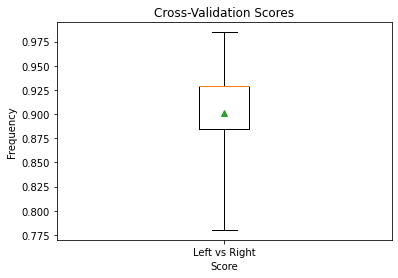

In [16]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.boxplot(scores,
           showmeans=True, # Green triangle marks the mean.
           whis=(0, 100),  # Whiskers span the entire range of the data.
           labels=['Left vs Right'])
ax.set_xlabel('Score')
ax.set_ylabel('Frequency')
ax.set_title('Cross-Validation Scores')


## We can do this more simply using the `mne.decoding` module! Let's go. 🚀

In [17]:
from sklearn.pipeline import make_pipeline
from mne.decoding import Scaler, Vectorizer, cross_val_multiscore

# First, create X and y.
epochs_grad = epochs.copy().pick_types(meg='grad')
X = epochs_grad.get_data()
y = epochs_grad.events[:, 2]

# Classifier pipeline.
clf = make_pipeline(
    # An MNE scaler that correctly handles different channel types –
    # isn't that great?!
    Scaler(epochs_grad.info),
    # Remember this annoying and error-prone NumPy array reshaping we had to do
    # earlier? Not anymore, thanks to the MNE vectorizer!
    Vectorizer(),
    # And, finally, the actual classifier.
    LogisticRegression())

# Run cross-validation.
# Note that we're using MNE's cross_val_multiscore() here, not scikit-learn's
# cross_val_score() as above. We simply pass the number of desired CV splits,
# and MNE will automatically do the rest for us.
n_splits = 5
scoring = 'roc_auc'
scores = cross_val_multiscore(clf, X, y, cv=5, scoring='roc_auc')

# Mean and standard deviation of ROC AUC across cross-validation runs.
roc_auc_mean = round(np.mean(scores), 3)
roc_auc_std = round(np.std(scores), 3)

print(f'CV scores: {scores}')
print(f'Mean ROC AUC = {roc_auc_mean:.3f} (SD = {roc_auc_std:.3f})')

CV scores: [0.98979592 0.92307692 0.97802198 0.8021978  0.92857143]
Mean ROC AUC = 0.924 (SD = 0.066)


## Decoding over time: Comparisons at every single time point.

In the previous examples, we have trained a classifier to discriminate between experimental conditions by using the spatio-temporal patterns of **entire trials**. Consequently, the classifier was (hopefully!) able to predict which activation patterns belonged to which condition. 

However, an interesting neuroscientific is: **Exactly *when* do the brain signals for two conditions differ?**

We can try to answer this question by fitting a classifier **at every single time point.** If the classifier can successfully discriminate between the two conditions, we can conclude that the spatial activation patterns measured by the MEG or EEG sensors differed **at this very time point**.

In [18]:
from sklearn.preprocessing import StandardScaler
from mne.decoding import SlidingEstimator

# First, create X and y.
epochs_grad = epochs.copy().pick_types(meg='grad')
X = epochs_grad.get_data()
y = epochs_grad.events[:, 2]

# Classifier pipeline. No need for vectorization as in the previous example.
clf = make_pipeline(StandardScaler(),
                    LogisticRegression())

# The "sliding estimator" will train the classifier at each time point.
scoring = 'roc_auc'
time_decoder = SlidingEstimator(clf, scoring=scoring, n_jobs=1, verbose=True)

# Run cross-validation.
n_splits = 5
scores = cross_val_multiscore(time_decoder, X, y, cv=5, n_jobs=1)

# Mean scores across cross-validation splits, for each time point.
mean_scores = np.mean(scores, axis=0)

# Mean score across all time points.
mean_across_all_times = round(np.mean(scores), 3)
print(f'\n=> Mean CV score across all time points: {mean_across_all_times:.3f}')



=> Mean CV score across all time points: 0.600


### Plot the classification results!

Text(0.5, 0.98, 'Sensor Space Decoding')

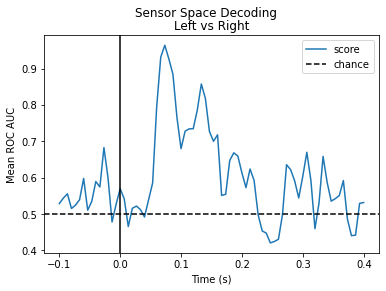

In [19]:
fig, ax = plt.subplots()

ax.plot(epochs.times, mean_scores, label='score')
ax.axhline(0.5, color='k', linestyle='--', label='chance')  # AUC = 0.5
ax.axvline(0, color='k', linestyle='-')  # Mark time point zero.

ax.set_xlabel('Time (s)')
ax.set_ylabel('Mean ROC AUC')
ax.legend()
ax.set_title('Left vs Right')
fig.suptitle('Sensor Space Decoding')

---------------

## Exercise I

- In the above example, we only used gradiometer (`grad`) channels. The sample data, however, also contains magnetometer (`mag`) and EEG (`eeg`) channels. Which sensor types produce the best classification scores?

- How does classification performance change if you alter the preprocessing parameters (filter cutoff frequencies, rejection parameters during epoching)?



## Exercise II 

The SPM `face` dataset shipping with MNE-Python contains MEG recordings from one participant who was presented with faces and scrambled faces in randomized order.

- Do a decoding over time on the SPM `face` dataset to see if you can classify `face` vs. `scrambled face`.

Hints:

- Access the `face` dataset via:

    ```
    sample_dir = Path(mne.datasets.spm_face.data_path())  # Downloads data.
    # Use str() here to work around a bug in MNE.
    raw_fname = str(sample_dir / 'MEG/spm/SPM_CTF_MEG_example_faces1_3D.ds')
    raw = mne.io.read_raw_ctf(raw_fname, preload=True)
    ```

- The event IDs are:

    ```
    event_ids = {'faces': 1, 'scrambled': 2}
    ```

- The trigger channel is `UPPT001`.

- Consider creating slightly longer epochs than for the auditory task.

- Consider setting an upper frequency limit for the filter which is well below the line noise frequency, e.g. `filter(l_freq=..., h_freq=40)`.

See this online example for additional hints: https://mne.tools/dev/auto_examples/datasets/spm_faces_dataset.html



### Example Solution

Using default location ~/mne_data for spm...



Verifying hash 9f43f67150e3b694b523a21eb929ea75.
Decompressing the archive: /root/mne_data/MNE-spm-face.tar.gz
(please be patient, this can take some time)
Successfully extracted to: ['/root/mne_data/MNE-spm-face']
ds directory : /root/mne_data/MNE-spm-face/MEG/spm/SPM_CTF_MEG_example_faces1_3D.ds
    res4 data read.
    hc data read.
    Separate EEG position data file not present.
    Quaternion matching (desired vs. transformed):
      -0.90   72.01    0.00 mm <->   -0.90   72.01   -0.00 mm (orig :  -43.09   61.46 -252.17 mm) diff =    0.000 mm
       0.90  -72.01    0.00 mm <->    0.90  -72.01   -0.00 mm (orig :   53.49  -45.24 -258.02 mm) diff =    0.000 mm
      98.30    0.00    0.00 mm <->   98.30   -0.00    0.00 mm (orig :   78.60   72.16 -241.87 mm) diff =    0.000 mm
    Coordinate transformations established.
    Polhemus data for 3 HPI coils added
    Device coordinate locations for 3 HPI coils added
    Measurement info composed.
Finding samples for /root/mne_data/MNE-spm



=> Mean CV score across all time points: 0.499


Text(0.5, 0.98, 'Sensor Space Decoding')

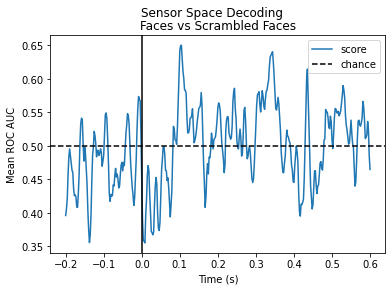

In [20]:
from pathlib import Path

from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import numpy as np

import mne
from mne.decoding import SlidingEstimator, cross_val_multiscore


# Load raw data.
data_path = Path(mne.datasets.spm_face.data_path())
raw_fname = str(data_path / 'MEG/spm/SPM_CTF_MEG_example_faces1_3D.ds')
raw = mne.io.read_raw_ctf(raw_fname, preload=True)

# High-pass filter the data.
raw.filter(l_freq=1, h_freq=40, verbose=True)

# Find events.
events = mne.find_events(raw, stim_channel='UPPT001', verbose=True)

# Create epochs.
event_id = {'faces': 1,
            'scrambled': 2}
tmin = -0.2  # Start of each epoch relative to the event marker (in seconds)
tmax = 0.6   # End of each epoch
baseline = None  # No baseline correction, data were high-pass filtered!
epochs = mne.Epochs(raw, tmin=tmin, tmax=tmax,
                    events=events, event_id=event_id,
                    baseline=baseline,
                    preload=True)  # Actually load the data into memory.
print(epochs)

# We don't need to equalize the number of trials, as we have the same number
# for each condition.

# Create X and y.
epochs_grad = epochs.copy().pick_types(meg='grad')
X = epochs_grad.get_data()
y = epochs_grad.events[:, 2]

# Classifier pipeline.
clf = make_pipeline(StandardScaler(),
                    LogisticRegression())

# The "sliding estimator" will train the classifier at each time point.
scoring = 'roc_auc'
time_decoder = SlidingEstimator(clf, scoring=scoring, n_jobs=1, verbose=True)

# Run cross-validation.
n_splits = 5
scores = cross_val_multiscore(time_decoder, X, y, cv=5, n_jobs=1)

# Mean scores across cross-validation splits, for each time point.
mean_scores = np.mean(scores, axis=0)

# Mean score across all time points.
mean_across_all_times = round(np.mean(scores), 3)
print(f'\n=> Mean CV score across all time points: {mean_across_all_times:.3f}')

# Plot scores.
fig, ax = plt.subplots()

ax.plot(epochs.times, mean_scores, label='score')
ax.axhline(0.5, color='k', linestyle='--', label='chance')  # AUC = 0.5
ax.axvline(0, color='k', linestyle='-')  # Mark time point zero.

ax.set_xlabel('Time (s)')
ax.set_ylabel('Mean ROC AUC')
ax.legend()
ax.set_title('Faces vs Scrambled Faces')
fig.suptitle('Sensor Space Decoding')

## Bonus Task

Temporal generalization or "generalization over time" (GAT) is an extension of the "decoding over time" approach we used above. It evaluates **whether the model estimated at a particular time instant accurately predicts any other time instant.**

Perform a GAT analysis as explained in the [MNE documentation on decoding](https://mne.tools/stable/auto_tutorials/machine-learning/plot_sensors_decoding.html#temporal-generalization).


-------

*For more information on decoding, see: https://mne.tools/stable/auto_tutorials/machine-learning/plot_sensors_decoding.html and this book chapter: Jean-Rémi King, Laura Gwilliams, Chris Holdgraf, Jona Sassenhagen, Alexandre Barachant, Denis Engemann, Eric Larson, Alexandre Gramfort. Encoding and Decoding Neuronal Dynamics: Methodological Framework to Uncover the Algorithms of Cognition. 2018. https://hal.archives-ouvertes.fr/hal-01848442/*